# "Binary" Options Analysis  and  "Lookback" Options Analysis
# Parameters Stress

# Claudio Ortiz

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 19 22:27:33 2019

@author: CLAUDIO ORTIZ,  PYTHON 3.6

THIS CODE IS WRITTEN SEGMENTED BY PARTS. IT FOLLOWS THE SAME NUMERIC INDEX
AS IN THE PDF REPORT FILE.

"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from scipy import stats
from scipy.stats import norm
from math import log,exp,sqrt

In [2]:
""" PRE SECTION. FUNCTIONS WE WILL USE ALONG THE REPORT  """

def euler_maruy(St,r,vol,dt,rand):
    """ Euler-Maruyama function. input St --> output St+1 """
    return St * ( 1 + r*dt + vol*rand*dt**(0.5) )

def d1(S, vol, r, K, T, divYld=0):
    return (log(S/K) + (r-divYld + 0.5*vol*vol) * T) /vol/sqrt(T)

def d2(S, vol, r, K, T, divYld=0):
    return d1(S, vol, r, K, T, divYld=0) - vol*sqrt(T)

def binary_call_bsm(S=100, vol=0.2, r=0.05, K=100, T=1, divYld=0):
    """ Black Scholes formulae for Binary Call Options"""
    return exp(-r*T) * norm.cdf(d2(S, vol, r, K, T, divYld=0))

def binary_put_bsm(S=100, vol=0.2, r=0.05, K=100, T=1, divYld=0):
    """ Black Scholes formulae for Binary Put Options"""
    return exp(-r*T) * (1- norm.cdf(d2(S, vol, r, K, T, divYld=0)) )

def vanilla_call(S=100, K=100, r=0.05, v=0.2, T=1):
    return S*norm.cdf(d1(S, v, r, K, T)) - K*exp(-r*T) * norm.cdf(d2(S, v, r, K, T))

def vanilla_put(S=100, K=100, r=0.05, v=0.2, T=1):
    return -S * norm.cdf(-d1(S, v, r, K, T)) + K*exp(-r*T) * norm.cdf(-d2(S, v, r, K, T))

def binary_opt_mc(S=100,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**4,call=True):
    """ Montecarlo Valuation of Binary Options. Stock price model Forward Euler-Maruyama """
    rands= np.random.normal(size=(num_paths,n))
    paths= np.empty([num_paths,n])
    paths[:,0]=S
    dt= T/n

    for i in range(0,num_paths): # populate Euler_Maruyama paths in matrix
        for j in range(1,n):
            paths[i,j]= paths[i,j-1] * ( 1 + r*dt + vol*rands[i,j]*dt**(0.5) )
    
    if call==True: # call
        return np.average( exp(-r*T)*np.where(np.maximum(paths[:,-1]-K,0) > 0, 1,0) )
    else: # put
        return np.average( exp(-r*T)*np.where(np.maximum(K-paths[:,-1],0) > 0, 1,0) )
    
def lookback_opt_fix(S=100,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**3,call=True):
    """ Montecarlo Valuation of Lookback Options, fixed strike. Discrete Sample
    Stock price model Forward Euler-Maruyama """
    rands= np.random.normal(size=(num_paths,n))
    paths= np.empty([num_paths,n])
    paths[:,0]=S
    dt= T/n

    for i in range(0,num_paths): # populate Euler_Maruyama paths in matrix
        for j in range(1,n):
            paths[i,j]= paths[i,j-1] * ( 1 + r*dt + vol*rands[i,j]*dt**(0.5) )
    
    if call==True: # call
        return np.average( exp(-r*T)*np.maximum(np.amax(paths,axis=1)-K,0) )
    else: # put
        return np.average( exp(-r*T)*np.maximum(K-np.amin(paths,axis=1),0) )

def lookback_opt_float(S=100,vol=0.2,r=0.05,T=1,n=252,num_paths=10**3,call=True):
    """ Montecarlo Valuation of Lookback Options, floating strike. Discrete Sample 
    Stock price model Forward Euler-Maruyama """
    rands= np.random.normal(size=(num_paths,n)) 
    paths= np.empty([num_paths,n])
    paths[:,0]=S
    dt= T/n

    for i in range(0,num_paths): # populate Euler_Maruyama paths in matrix
        for j in range(1,n):
            paths[i,j]= paths[i,j-1] * ( 1 + r*dt + vol*rands[i,j]*dt**(0.5) )
    
    if call==True: # call
        return np.average( exp(-r*T)* (paths[:,-1] - np.amin(paths,axis=1) ) )
    else: # put
        return np.average( exp(-r*T)* ( np.amax(paths,axis=1) - paths[:,-1]  )) 

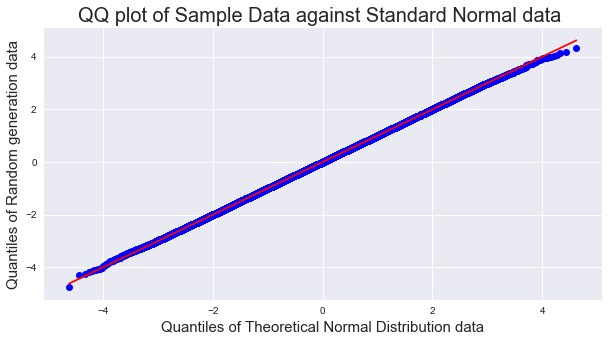

In [3]:
""" 1.2.1 GENERATED RANDOM DATA: NORMALITY TEST """

S0=100           # Stock Initial Value
K=100            # Strike
r= 0.05          # interest Rate
vol= 0.2         # Volatility
T=1              # Time to Maturity
n= 365           # number of steps
dt = T/n         # Time step size
num_paths= 10**3 # montecarlo number of paths

rands= np.random.normal(size=(num_paths,n))
r2= np.reshape(rands,(num_paths*n))

#PLot
plt.figure(figsize=(10,5))
stats.probplot(r2,plot=plt)
plt.title("QQ plot of Sample Data against Standard Normal data ",fontsize=20)
plt.xlabel('Quantiles of Theoretical Normal Distribution data',fontsize=15)
plt.ylabel('Quantiles of Random generation data', fontsize=15)
plt.show()

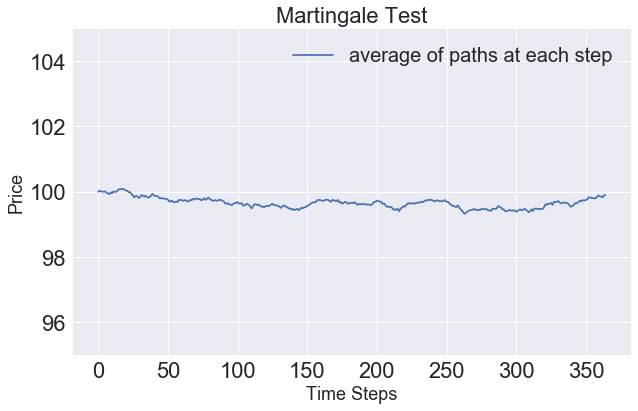

In [5]:
""" 1.2.2 GENERATED DATA MARTINGALE TEST , hacerlo con 10.000 paths pa que se vea bien""" 

paths= np.empty([num_paths,n])
paths[:,0]=S0

for i in range(0,num_paths): # populate paths in matrix
    for j in range(1,n):
        paths[i,j]= euler_maruy( paths[i,j-1] ,r,vol,dt,rands[i,j] )  # stock steps

def pv(x1,r,dt,x2):
    """ present value of stock value at any step in time"""
    return x1 * exp(-r*dt*x2)

paths_pv= np.empty([num_paths,n])
for ii in range(n):
    paths_pv[:,ii]= pv(paths[:,ii],r,dt,ii)

pd.DataFrame(np.average(paths_pv,axis=0),columns=['average of paths at each step']).plot(
        figsize=(10,6),fontsize=22,ylim=(95,105))
plt.title("Martingale Test", fontsize=22)
plt.legend(prop={'size': 20})
plt.xlabel('Time Steps',fontsize=18)
plt.ylabel('Price',fontsize=18)
plt.show()


Text(0,0.5,'Option Value')

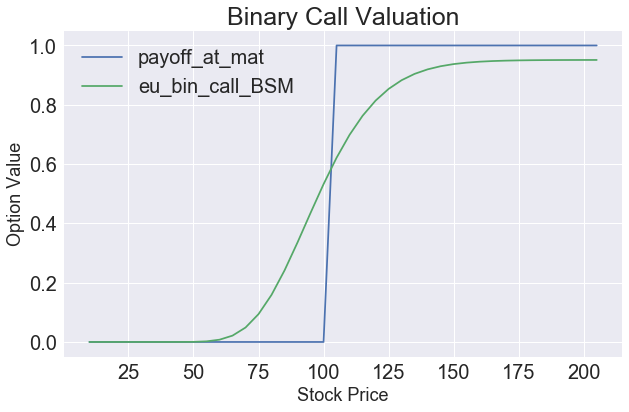

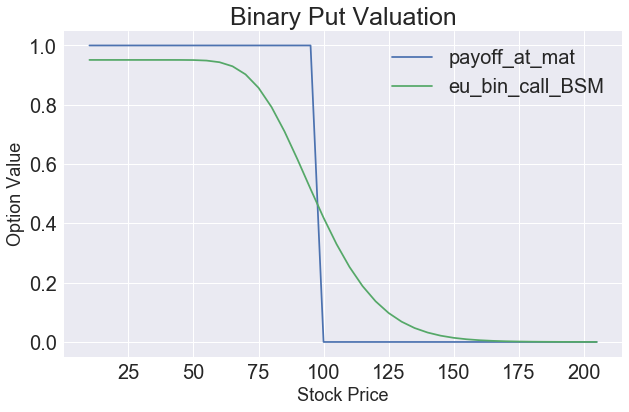

In [6]:
""" 2.1 BINARY OPTIONS BLACK SCHOLES MODEL  """

""" CALL OPTIONS """
dfc= pd.DataFrame(index=[i for i in range(10, 210,5)])
dfc['payoff_at_mat']  = np.where(dfc.index>100,1,0)
dfc['eu_bin_call_BSM']= pd.Series(dfc.index, index=dfc.index).apply(lambda x: binary_call_bsm(
                        S=x,vol=0.2,r=0.05,K=100,T=1))

""" PUT OPTIONS """
dfp= pd.DataFrame(index=[i for i in range(10, 210,5)])

dfp['payoff_at_mat']  = np.where(dfp.index<100,1,0)
dfp['eu_bin_call_BSM']= pd.Series(dfp.index, index=dfp.index).apply(lambda x: binary_put_bsm(
                        S=x,vol=0.2,r=0.05,K=100,T=1))

#PLot calls
dfc[['payoff_at_mat','eu_bin_call_BSM']].plot(figsize=(10,6),fontsize=20)
plt.legend(loc=2,prop={'size': 20})
plt.title("Binary Call Valuation", fontsize=25)
plt.xlabel('Stock Price', fontsize=18)
plt.ylabel('Option Value', fontsize=18)

#Plot puts
dfp[['payoff_at_mat','eu_bin_call_BSM']].plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Binary Put Valuation", fontsize=25)
plt.xlabel('Stock Price', fontsize=18)
plt.ylabel('Option Value', fontsize=18)

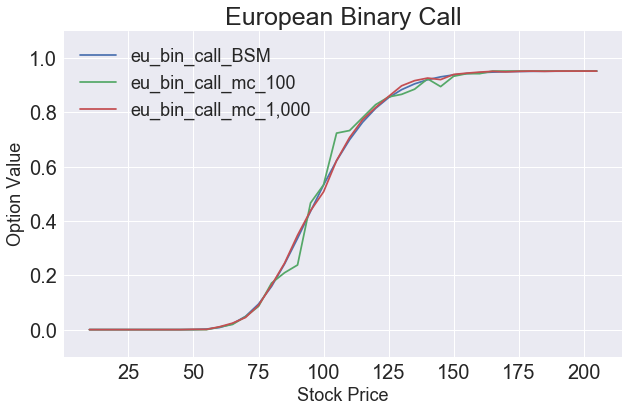

In [7]:
""" 2.2 BINARY OPTIONS: MONTECARLO V/S BSM """

""" CALL OPTIONS """
dfc['eu_bin_call_mc_100']= pd.Series(dfc.index, index=dfc.index).apply(lambda x: binary_opt_mc(
                        S=x,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**2,call=True))

dfc['eu_bin_call_mc_1,000']= pd.Series(dfc.index, index=dfc.index).apply(lambda x: binary_opt_mc(
                        S=x,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**3,call=True))

#plot --> Black Scholes compared to Montecarlo
dfc.iloc[:,1:].plot(figsize=(10,6),fontsize=20,ylim=(-0.1,1.1),kind='line')
plt.legend(loc=2,prop={'size': 18})
plt.title("European Binary Call", fontsize=25)
plt.xlabel('Stock Price', fontsize=18)
plt.ylabel('Option Value', fontsize=18)
plt.show()

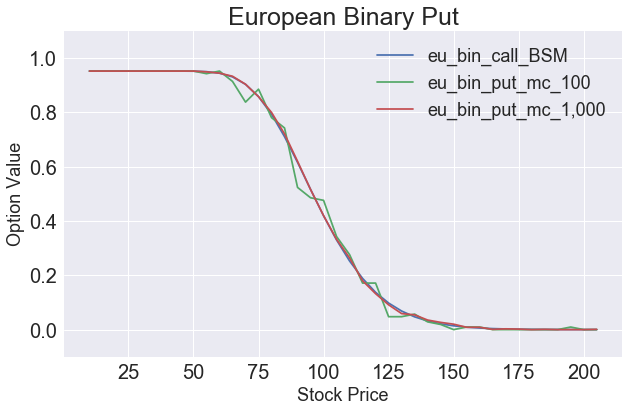

In [8]:
""" PUT OPTIONS """
dfp['eu_bin_put_mc_100']= pd.Series(dfp.index, index=dfp.index).apply(lambda x: binary_opt_mc(
                        S=x,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**2,call=False))

dfp['eu_bin_put_mc_1,000']= pd.Series(dfp.index, index=dfp.index).apply(lambda x: binary_opt_mc(
                        S=x,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=10**3,call=False))

#plot --> Black Scholes compared to Montecarlo
dfp.iloc[:,1:].plot(figsize=(10,6),fontsize=20,ylim=(-0.1,1.1),kind='line')
plt.legend(loc=1,prop={'size': 18})
plt.title("European Binary Put", fontsize=25)
plt.xlabel('Stock Price', fontsize=18)
plt.ylabel('Option Value', fontsize=18)
plt.show()

In [9]:
""" 2.3.1  MONTECARLO PERFORMANCE ON DIFFERENT NUMBER OF PATH SIMULATIONS  """


""" TABLE 1 CALLS: run BSM, then Montecarlos from 10 to 10,000"""

bsm_call= binary_call_bsm()
dfec=pd.DataFrame(index=list(range(100)), columns=[10,100,1000,10000])
counter=0
for x in [10,100,1000,10000]:
    for times in range(100):
        e= binary_opt_mc(num_paths=x,call=True) - bsm_call
        dfec.iloc[times,counter]= e
    counter += 1
dfec.mean(axis=0)

""" TABLE 1 PUTS: run BSM, then Montecarlos from 10 to 10,000"""

bsm_put= binary_put_bsm() 
dfep=pd.DataFrame(index=list(range(100)), columns=[10,100,1000,10000])
counter=0
for x in [10,100,1000,10000]:
    for times in range(100):
        e= binary_opt_mc(num_paths=x,call=False) - bsm_put
        dfep.iloc[times,counter]= e
    counter += 1
dfep.mean(axis=0)

10      -0.014632
100      0.005439
1000    -0.002171
10000    0.000502
dtype: float64

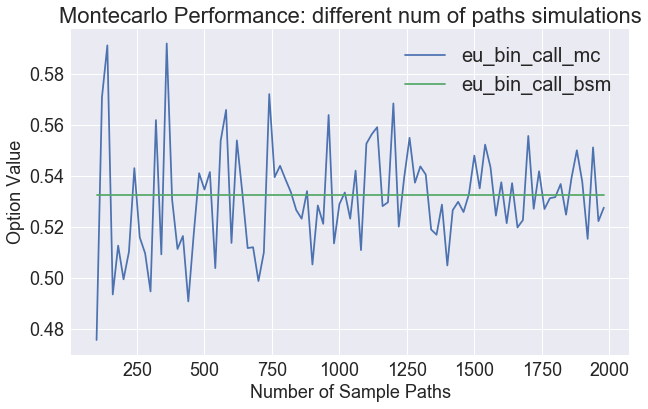

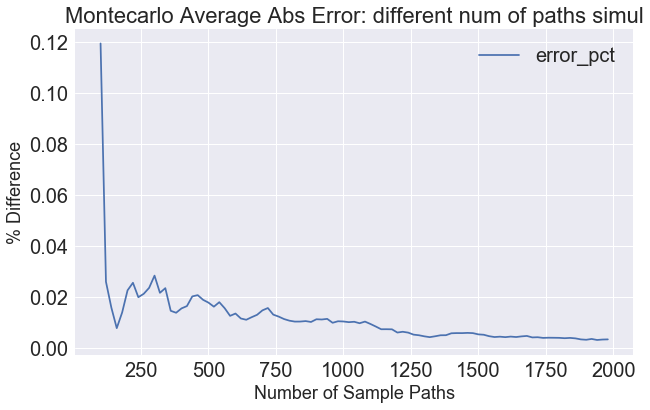

In [10]:
""" 2.3.2  MONTECARLO PERFORMANCE ON DIFFERENT NUMBER OF PATH SIMULATIONS  """


# Valuation from 100 paths to 10,000 paths
df_num_paths= pd.DataFrame(index=[i for i in range(10**2, 10**3+1000,10*2)])

df_num_paths['eu_bin_call_mc']= pd.Series(df_num_paths.index, index=df_num_paths.index).apply(lambda x: \
        binary_opt_mc(S=100,vol=0.2,r=0.05,K=100,T=1,n=252,num_paths=x,call=True))

df_num_paths['eu_bin_call_bsm']=binary_call_bsm(S=100,vol=0.2,r=0.05,K=100,T=1)

df_num_paths['error_pct']= (df_num_paths.iloc[:,1]-df_num_paths.iloc[:,0] ) / df_num_paths.iloc[:,0]
df_num_paths.error_pct= df_num_paths.error_pct.expanding(min_periods=1).mean()

#Plot
df_num_paths.iloc[:,:-1].plot(figsize=(10,6),fontsize=18,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo Performance: different num of paths simulations", fontsize=22)
plt.xlabel('Number of Sample Paths', fontsize=18)
plt.ylabel('Option Value', fontsize=18)
plt.show()

#Plot
abs(df_num_paths.iloc[:,-1]).plot(figsize=(10,6),fontsize=20,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo Average Abs Error: different num of paths simul", fontsize=22)
plt.xlabel('Number of Sample Paths', fontsize=18)
plt.ylabel('% Difference', fontsize=18)
plt.show()

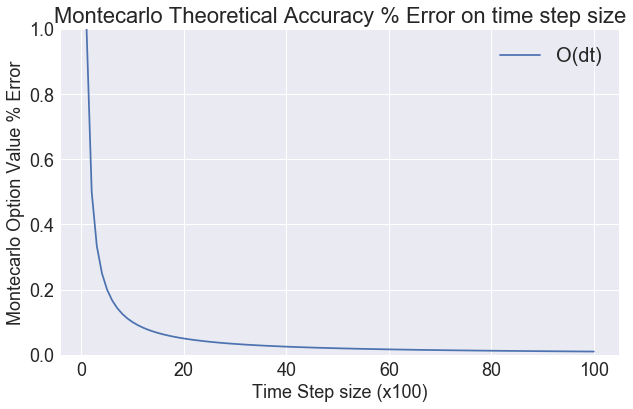

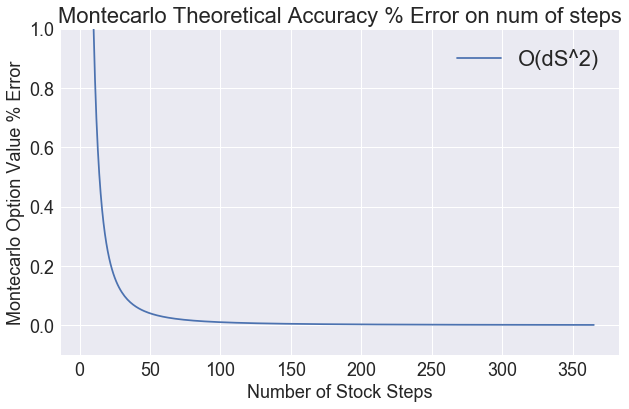

In [11]:
""" 2.4  MONTECARLO PERFORMANCE ON DIFFERENT NUMBER OF STEPS  """


""" 2.4.1 Montecarlo Theoretical Accuracy Error on TIME step size"""
df_err_dt= pd.DataFrame(index=[i for i in range(1,100+1)])
df_err_dt['O(dt)']=( 1/df_err_dt.index/100) *100

#Plot
df_err_dt.plot(figsize=(10,6),fontsize=18,kind='line',ylim=(0,1))
plt.legend(prop={'size': 20})
plt.title("Montecarlo Theoretical Accuracy % Error on time step size", fontsize=22)
plt.xlabel('Time Step size (x100)', fontsize=18)
plt.ylabel('Montecarlo Option Value % Error', fontsize=18)
plt.show()


""" 2.4.2 Montecarlo Theoretical Accuracy Error on NUMBER of stock STEPS """
df_err_ds= pd.DataFrame(index=[i for i in range(5, 365+1)])
df_err_ds['O(dS^2)']= ( (1/df_err_ds.index**2) ) *100

#PLot
df_err_ds.plot(figsize=(10,6),fontsize=18,kind='line',ylim=(-0.1,1))
plt.legend(prop={'size': 22})
plt.title("Montecarlo Theoretical Accuracy % Error on num of steps", fontsize=22)
plt.xlabel('Number of Stock Steps', fontsize=18)
plt.ylabel('Montecarlo Option Value % Error', fontsize=18)
plt.show()

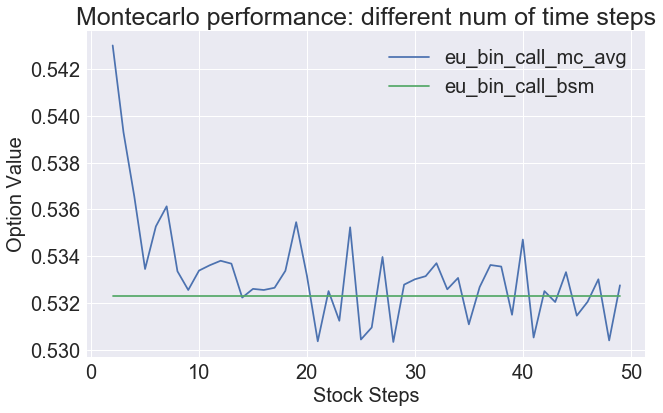

In [12]:
""" 2.4.3 Montecarlo Accuracy Error on number of time steps, our simulation """
df_steps= pd.DataFrame(index=[i for i in range(2,50,1)])

for j in range(100):
    df_steps['eu_bin_call_mc_'+str(j)]= pd.Series(df_steps.index, index=df_steps.index).apply(lambda x: \
            binary_opt_mc(n=x,num_paths=10**3,call=True))
df_steps= pd.DataFrame(df_steps.mean(axis=1), columns=['eu_bin_call_mc_avg'])

df_steps['eu_bin_call_bsm']=binary_call_bsm(S=100,vol=0.2,r=0.05,K=100,T=1)

#Plot
df_steps.plot(figsize=(10,6),fontsize=20,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo performance: different num of time steps", fontsize=25)
plt.xlabel('Stock Steps', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

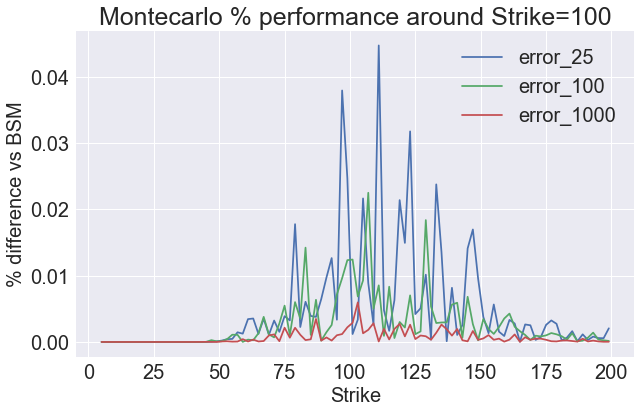

In [13]:
""" 2.5  MONTECARLO PERFORMANCE ERROR AROUND STRIKE """

dfk= pd.DataFrame(index=[i for i in range(5,200,2)])

dfk['bin_call_bsm']= pd.Series(dfk.index, index=dfk.index).apply(lambda x: \
        binary_call_bsm(K=x) )

for j in range(30):
    dfk['bin_call_mc_25_'+str(j)]= pd.Series(dfk.index, index=dfk.index).apply(lambda x: \
        binary_opt_mc(K=x,num_paths=25))

for j in range(30):
    dfk['bin_call_mc_100_'+str(j)]= pd.Series(dfk.index, index=dfk.index).apply(lambda x: \
        binary_opt_mc(K=x,num_paths=100))

for j in range(30):
    dfk['bin_call_mc_1000_'+str(j)]= pd.Series(dfk.index, index=dfk.index).apply(lambda x: \
        binary_opt_mc(K=x,num_paths=1000))

# Errors
dfk['error_25']= abs(dfk.iloc[:,1:31].mean(axis=1)-dfk.bin_call_bsm)
dfk['error_100']= abs(dfk.iloc[:,31:61].mean(axis=1)-dfk.bin_call_bsm)
dfk['error_1000']= abs(dfk.iloc[:,61:91].mean(axis=1)-dfk.bin_call_bsm)

#Plot Monetcarlo Option Value Error in Nominal terms
abs(dfk.iloc[:,-3:]).plot(figsize=(10,6),fontsize=20,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo % performance around Strike=100", fontsize=25)
plt.xlabel('Strike', fontsize=20)
plt.ylabel('% difference vs BSM', fontsize=20)
plt.show()

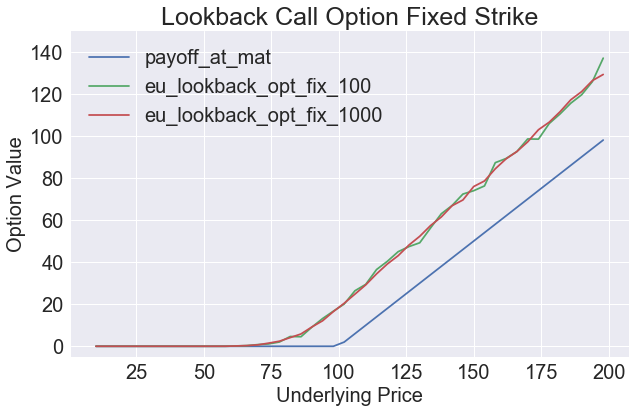

In [14]:
""" 3.1.1 LOOKBACK CALL OPTION FIXED STRIKE - Discrete Sampling """

dflc= pd.DataFrame(index=[i for i in range(10,200,4)])

dflc['payoff_at_mat']= np.where(dflc.index>100,dflc.index-100,0)

dflc['eu_lookback_opt_fix_100']= pd.Series(dflc.index, index=dflc.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**2))

dflc['eu_lookback_opt_fix_1000']= pd.Series(dflc.index, index=dflc.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**3))

#Plot
dflc.plot(figsize=(10,6),fontsize=20,ylim=(-5,150))
plt.legend(prop={'size': 20})
plt.title("Lookback Call Option Fixed Strike", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

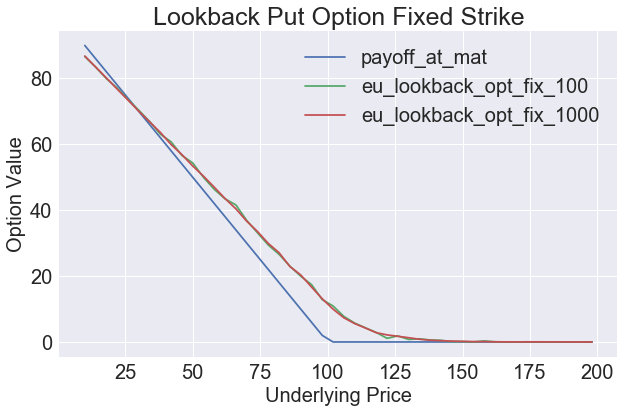

In [15]:
""" 3.1.1 LOOKBACK PUT OPTIONS FIXED STRIKE - Discrete Sampling """

dflp= pd.DataFrame(index=[i for i in range(10,200,4)])

dflp['payoff_at_mat']= np.where(dflp.index>100,0,100-dflp.index)

dflp['eu_lookback_opt_fix_100']= pd.Series(dflp.index, index=dflp.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**2,call=False))

dflp['eu_lookback_opt_fix_1000']= pd.Series(dflp.index, index=dflp.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**3,call=False))

# Plot
dflp.plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Put Option Fixed Strike", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

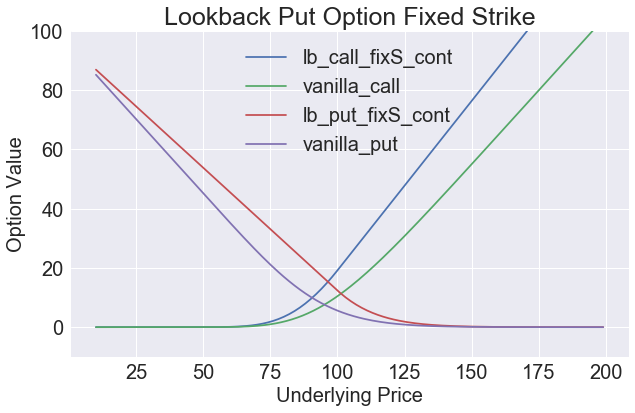

In [16]:
""" 3.1.2 LOOKBACK CALL OPTIONS FIXED STRIKE - Continuous Sampling """

#CALL OPTION VALUE
def lb_fix_call(S=100, r=0.05, v= 0.20, T=1, K=100):
    """ lookback call Option FIXED strike- closed form solution """
    if S <= K:
        d1= (log(S/K) + (r+(v**2)/2)*T  ) / (v*sqrt(T))
        d2= d1 - v*sqrt(T)
        d3= d1-2*r*sqrt(T)/v
        A= exp(r*T)*norm.cdf(d1) - ((S/K)**(-2*r/v**2))*norm.cdf(d3)
        return S*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) + S*exp(-r*T) * (v**2/(2*r)) * A
    if S > K:
        d1= (log(S/S) + (r+(v**2)/2)*T  ) / (v*sqrt(T))
        d2= d1 - v*sqrt(T)
        d3= d1-2*r*sqrt(T)/v     
        A= exp(r*T)*norm.cdf(d1) - ((S/S)**(-2*r/v**2))*norm.cdf(d3)
        return (S-K)*exp(-r*T) + S*norm.cdf(d1) - S*exp(-r*T)*norm.cdf(d2) + S*exp(-r*T)*(v**2/(2*r)) * A


# PUT OPTION VALUE
def lb_fix_put(S=100, r=0.05, v= 0.20, T=1, K=100):
    """ lookback put Option FIXED strike - closed form solution """
    if S >= K:
        d1= (-log(S/K) - (r-(v**2)/2)*T  ) / (v*sqrt(T))
        d2= d1 - v*sqrt(T)
        d3= d2 + 2*r*sqrt(T)/v
        A= -exp(r*T)*norm.cdf(d2) + (S/K)**(-2*r/v**2)*norm.cdf(d3)       
        return -S*norm.cdf(d2)+ K*exp(-r*T)*norm.cdf(d1)+ S*exp(-r*T)*(v**2/(2*r))* A
    if S < K:
        d1= (-log(S/S) - (r-(v**2)/2)*T  ) / (v*sqrt(T))
        d2= d1 - v*sqrt(T)
        d3= d2 + 2*r*sqrt(T)/v
        A= (S/S)**(-2*r/v**2)*norm.cdf(d3)-exp(r*T)*norm.cdf(d2)      
        return (K-S)*exp(-r*T) - S*norm.cdf(d2) + S*exp(-r*T)*norm.cdf(d1)+ S*exp(-r*T)*(v**2/(2*r))*A
    

dflfic= pd.DataFrame(index=[i for i in range(10,200,1)])

dflfic['lb_call_fixS_cont']= pd.Series(dflfic.index, index=dflfic.index).apply(lambda x: \
                                      lb_fix_call(S=x))
dflfic['vanilla_call']= pd.Series(dflfic.index, index=dflfic.index).apply(lambda x: \
                                      vanilla_call(S=x))

dflfic['lb_put_fixS_cont']= pd.Series(dflfic.index, index=dflfic.index).apply(lambda x: \
                                      lb_fix_put(S=x))
dflfic['vanilla_put']= pd.Series(dflfic.index, index=dflfic.index).apply(lambda x: \
                                      vanilla_put(S=x))

# Plot
dflfic.plot(figsize=(10,6),fontsize=20,ylim=(-10,100))
plt.legend(prop={'size': 20})
plt.title("Lookback Put Option Fixed Strike", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

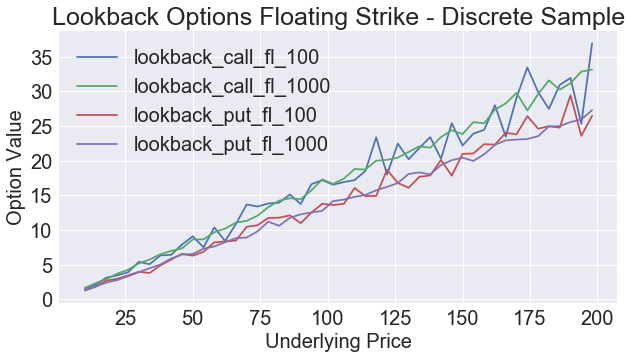

In [17]:
""" 3.2.1 LOOKBACK CALL OPTION FLOATING STRIKE Discrete Sampling  """

dflfl= pd.DataFrame(index=[i for i in range(10,200,4)])

dflfl['lookback_call_fl_100']= pd.Series(dflfl.index, index=dflfl.index).apply(lambda x: \
                                      lookback_opt_float(S=x,num_paths=10**2))

dflfl['lookback_call_fl_1000']= pd.Series(dflfl.index, index=dflfl.index).apply(lambda x: \
                                      lookback_opt_float(S=x,num_paths=10**3))


""" 3.2.1 LOOKBACK PUT OPTION FLOATING STRIKE Discrete Sampling  """

dflfl['lookback_put_fl_100']= pd.Series(dflfl.index, index=dflfl.index).apply(lambda x: \
                                      lookback_opt_float(S=x,num_paths=10**2,call=False))

dflfl['lookback_put_fl_1000']= pd.Series(dflfl.index, index=dflfl.index).apply(lambda x: \
                                      lookback_opt_float(S=x,num_paths=10**3,call=False))

# Plot
dflfl.plot(figsize=(10,5),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Options Floating Strike - Discrete Sample", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

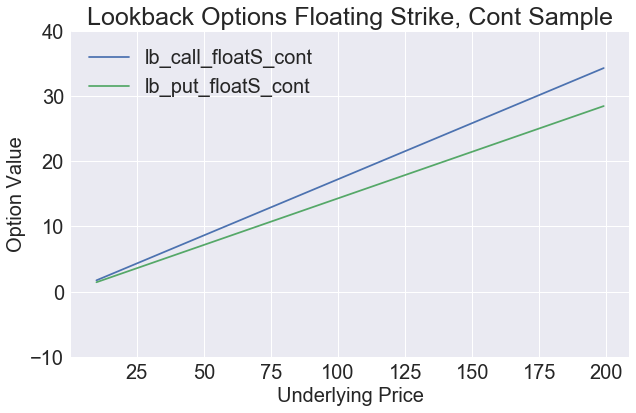

In [18]:
""" 3.2.2 LOOKBACK CALL OPTION FLOATING STRIKE - Continuous Sampling  """


def lb_float_call(S=100, r=0.05, v = 0.20, T=1, K=100):
    """ lookback call Option FLOATING strike- closed form solution """    
    d1= (log(S/K) + (r + (v**2)/2)*T)/ (v*sqrt(T))
    d2= d1 - v*sqrt(T)
    d3= -d1 + 2*r * sqrt(T) / v
    A= (S/K)**(-2*r/v**2)*norm.cdf(d3) - exp(r*T)*norm.cdf(-d1)
    return S*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2) + S*exp(-r*T) * (v**2/(2*r)) * A


""" 3.2.2 LOOKBACK PUT OPTION FLOATING STRIKE - Continuous Sampling  """

def lb_float_put(S=100, r=0.05, v = 0.20, T=1, K=100):
    """ lookback Put Option FLOATING strike- closed form solution """
    d1= (-log(S/K) - (r-(v**2)/2)*T  ) / (v*sqrt(T))
    d2= d1 - v*sqrt(T)
    d3= -d2 - 2*r * sqrt(T) / v
    A= exp(r*T)*norm.cdf(-d2) - (S/K)**(-2*r/v**2)*norm.cdf(d3)  
    
    return K*exp(-r*T)*norm.cdf(d1) - S*norm.cdf(d2) + S*exp(-r*T)*(v**2/(2*r)) * A


dflflc= pd.DataFrame(index=[i for i in range(10,200,1)])

dflflc['lb_call_floatS_cont']= pd.Series(dflflc.index, index=dflflc.index).apply(lambda x: \
                                      lb_float_call(S=x,K=x))

dflflc['lb_put_floatS_cont']= pd.Series(dflflc.index, index=dflflc.index).apply(lambda x: \
                                      lb_float_put(S=x,K=x))

# Plot
dflflc.plot(figsize=(10,6),fontsize=20,ylim=(-10,40))
plt.legend(prop={'size': 20})
plt.title("Lookback Options Floating Strike, Cont Sample", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

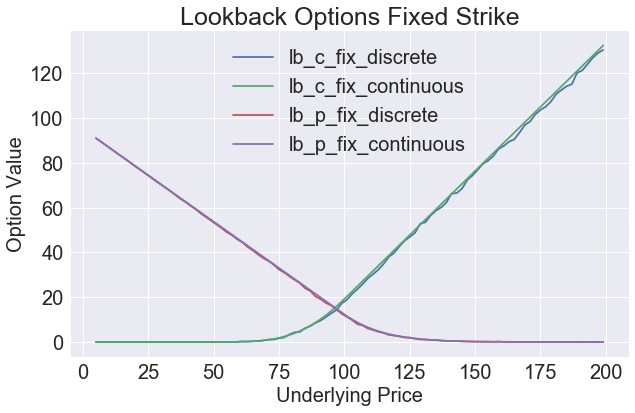

In [19]:
""" 3.3    Discrete Sample vs Continuous. Fixed Strike Options """

df33= pd.DataFrame(index=[i for i in range(5,200,2)])

df33['lb_c_fix_discrete']= pd.Series(df33.index,index=df33.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**3,call=True))

df33['lb_c_fix_continuous']= pd.Series(df33.index, index=df33.index).apply(lambda x:\
                                        lb_fix_call(S=x))

df33['lb_p_fix_discrete']= pd.Series(df33.index,index=df33.index).apply(lambda x: \
                                      lookback_opt_fix(S=x,num_paths=10**3,call=False))

df33['lb_p_fix_continuous']= pd.Series(df33.index, index=df33.index).apply(lambda x: \
                                        lb_fix_put(S=x))


#Plot
df33.plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Options Fixed Strike", fontsize=25)
plt.xlabel('Underlying Price', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

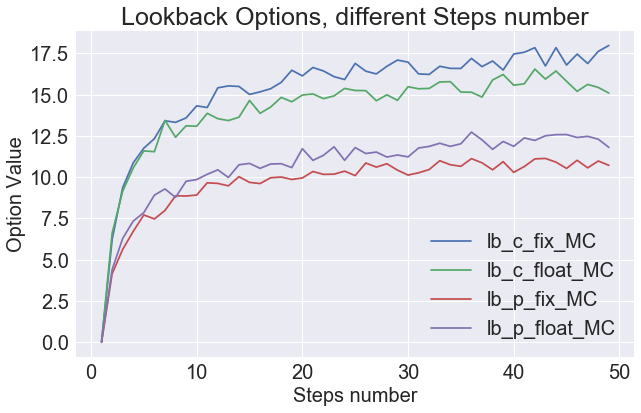

In [20]:
""" 3.4.	Different Performance on Steps definition """

df4= pd.DataFrame(index=[i for i in range(1,50,1)])

df4['lb_c_fix_MC']= pd.Series(df4.index,index=df4.index).apply(lambda x: \
                                      lookback_opt_fix(n=x,num_paths=10**3,call=True))
df4['lb_c_float_MC']= pd.Series(df4.index,index=df4.index).apply(lambda x: \
                                      lookback_opt_float(n=x,num_paths=10**3,call=True))

df4['lb_p_fix_MC']= pd.Series(df4.index,index=df4.index).apply(lambda x: \
                                      lookback_opt_fix(n=x,num_paths=10**3,call=False))
df4['lb_p_float_MC']= pd.Series(df4.index,index=df4.index).apply(lambda x: \
                                      lookback_opt_float(n=x,num_paths=10**3,call=False))

#Plot
df4.plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Options, different Steps number", fontsize=25)
plt.xlabel('Steps number', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

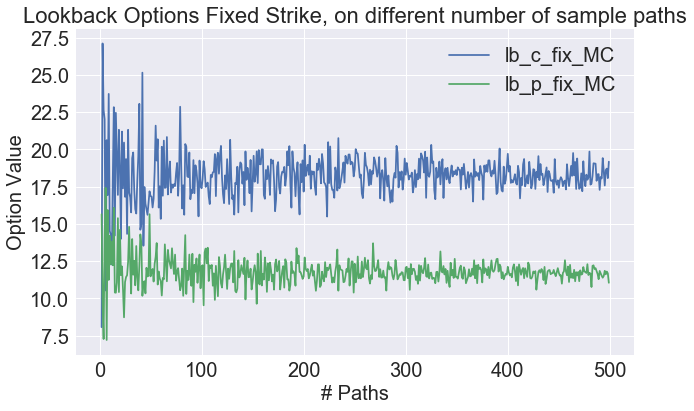

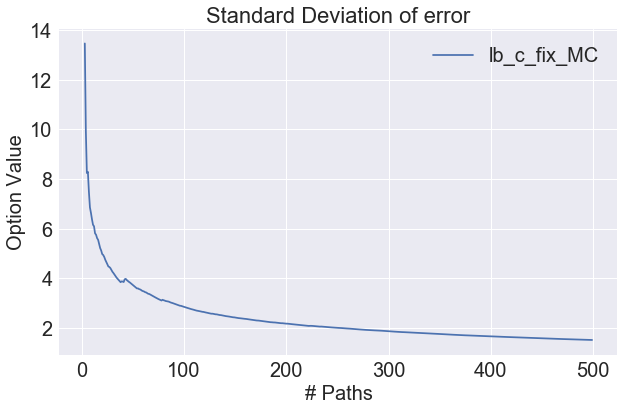

In [21]:
""" 3.5.1	Lookback Options FIXED STRIKE on Different number of sample paths """

df5= pd.DataFrame(index=[i for i in range(2,500)])

df5['lb_c_fix_MC']= pd.Series(df5.index,index=df5.index).apply(lambda x: \
                                      lookback_opt_fix(num_paths=x,call=True))

df5['lb_p_fix_MC']= pd.Series(df5.index,index=df5.index).apply(lambda x: \
                                      lookback_opt_fix(num_paths=x,call=False))

#Plot
df5.plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Options Fixed Strike, on different number of sample paths", fontsize=22)
plt.xlabel('# Paths', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

#Plot standard deviation of error
df5.iloc[:,0].expanding(min_periods=1).std().plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Standard Deviation of error", fontsize=22)
plt.xlabel('# Paths', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

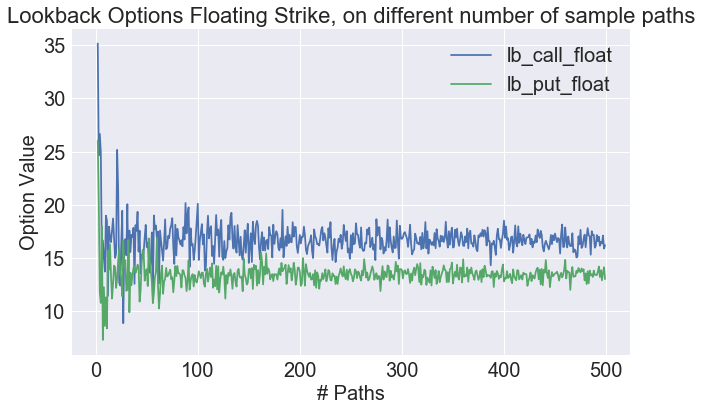

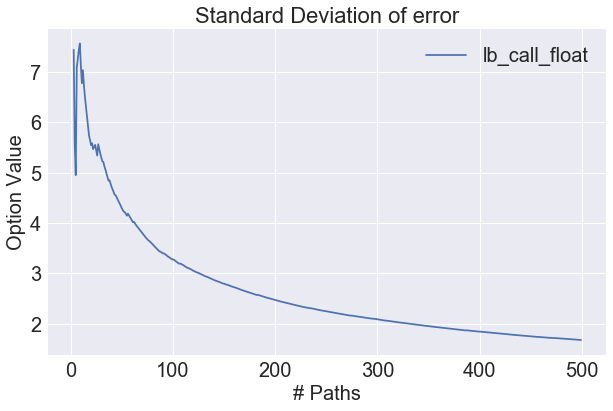

In [22]:
""" 3.5.2	Lookback Options FLOATING STRIKE on Different number of sample paths """

df55= pd.DataFrame(index=[i for i in range(2,500)])

df55['lb_call_float']= pd.Series(df55.index,index=df55.index).apply(lambda x: \
                                      lookback_opt_float(num_paths=x,call=True))

df55['lb_put_float']= pd.Series(df55.index,index=df55.index).apply(lambda x: \
                                      lookback_opt_float(num_paths=x,call=False))

#Plot
df55.plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Lookback Options Floating Strike, on different number of sample paths", fontsize=22)
plt.xlabel('# Paths', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

#Plot standard deviation of error
df55.iloc[:,0].expanding(min_periods=1).std().plot(figsize=(10,6),fontsize=20)
plt.legend(prop={'size': 20})
plt.title("Standard Deviation of error", fontsize=22)
plt.xlabel('# Paths', fontsize=20)
plt.ylabel('Option Value', fontsize=20)
plt.show()

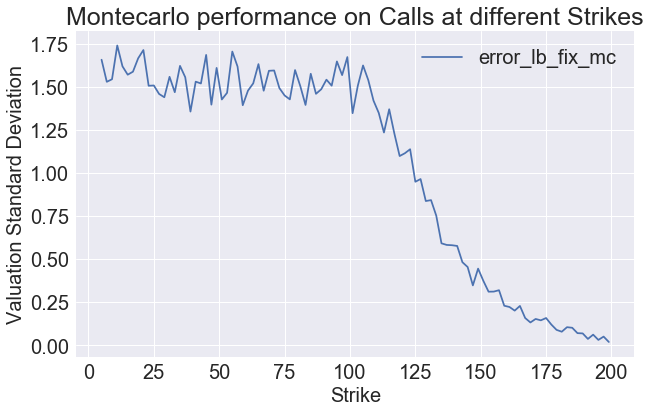

In [23]:
""" 3.6.1     FIXED STRIKE CALL OPTIONS. Montecarlo Error around Strike """

df6= pd.DataFrame(index=[i for i in range(5,200,2)])

for j in range(100):
    df6['lb_fix_mc'+str(j)]= pd.Series(df6.index, index=df6.index).apply(lambda x: \
        lookback_opt_fix(K=x,num_paths=100))

# We look for the standard deviation of valuations at each Strike
df6['error_lb_fix_mc']= abs(df6.std(axis=1))

#Plot Monetcarlo Option Value Error in Nominal terms
abs(df6.iloc[:,-1]).plot(figsize=(10,6),fontsize=20,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo performance on Calls at different Strikes", fontsize=25)
plt.xlabel('Strike', fontsize=20)
plt.ylabel('Valuation Standard Deviation', fontsize=20)
plt.show()

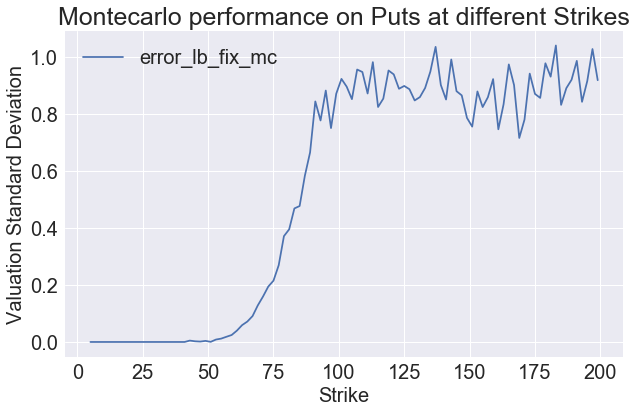

In [24]:
""" 3.6.2    FIXED STRIKE PUT OPTIONS. Montecarlo Error around Strike """

df61= pd.DataFrame(index=[i for i in range(5,200,2)])

for j in range(100):
    df61['lb_fix_mc'+str(j)]= pd.Series(df61.index, index=df61.index).apply(lambda x: \
        lookback_opt_fix(K=x,num_paths=100,call=False))

# We look for the standard deviation of valuations at each Strike
df61['error_lb_fix_mc']= abs(df61.std(axis=1))

#Plot Monetcarlo Option Value Error in Nominal terms
abs(df61.iloc[:,-1]).plot(figsize=(10,6),fontsize=20,kind='line')
plt.legend(prop={'size': 20})
plt.title("Montecarlo performance on Puts at different Strikes", fontsize=25)
plt.xlabel('Strike', fontsize=20)
plt.ylabel('Valuation Standard Deviation', fontsize=20)
plt.show()